# Projeto 2: Classificação binária brest cancer com validação cruzada e dropout

## Etapa 1: Importação das bibliotecas

In [50]:
import pandas as pd
import numpy as np
import torch.nn as nn
import skorch # para validacao cruzada
from skorch import NeuralNetBinaryClassifier
import torch
import seaborn as sns
import sklearn
from sklearn.model_selection import cross_val_score, train_test_split

In [51]:
torch.__version__, skorch.__version__, sklearn.__version__

('2.4.0+cu121', '1.0.0', '1.5.1')

## Etapa 2: Base de dados

In [52]:
np.random.seed(123)
torch.manual_seed(123)

In [53]:
previsores = pd.read_csv('./content/entradas-breast.csv')
classe = pd.read_csv('./content/saidas-breast.csv')

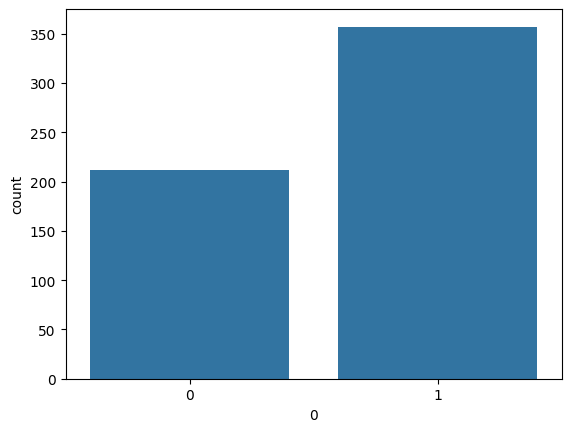

In [54]:
sns.countplot(x = classe['0']);

In [10]:
classe.shape

(569, 1)

In [55]:
previsores_treinamento, previsores_teste, classe_treinamento, classe_teste = train_test_split(previsores,
                                                                                              classe,
                                                                                              test_size = 0.25)

In [56]:
previsores = np.array(previsores_treinamento, dtype='float32')
classe = np.array(classe_treinamento, dtype='float32').squeeze(1)

In [12]:
classe.shape

(569,)

In [13]:
type(previsores)

numpy.ndarray

In [14]:
type(classe)

numpy.ndarray

## Etapa 3: Classe para estrutura da rede neural

** ATUALIZAÇÃO DEZ/2021 **: na versão atual do Skorch, os resultados da rede neural devem ser retornados sem ativação, ou seja, sem a camada sigmoide no final. Com isto, a função de custo deve ser `BCEWithLogitsLoss`.

In [60]:
class classificador_torch(nn.Module): # vai herdar de nn.Module
  def __init__(self):
    super().__init__() # herdando todas as caracteristicas

    # 30 -> 16 -> 16 -> 1
    self.dense0 = nn.Linear(30, 16)
    torch.nn.init.uniform_(self.dense0.weight) #inicia os pesos em distribuicao uniforme
    self.activation0 = nn.ReLU()
    self.dense1 = nn.Linear(16, 16)
    torch.nn.init.uniform_(self.dense1.weight)
    self.activation1 = nn.ReLU()
    self.dense2 = nn.Linear(16, 1)
    torch.nn.init.uniform_(self.dense2.weight)
    # self.output = nn.Sigmoid() ** ATUALIZAÇÃO (ver detalhes no texto acima) **

  def forward(self, X): # faz a comunicacao (ligacao) das camadas criadas acima
    X = self.dense0(X)
    X = self.activation0(X)
    X = self.dense1(X)
    X = self.activation1(X)
    X = self.dense2(X)
    # X = self.output(X) ** ATUALIZAÇÃO (ver detalhes no texto acima) **
    return X

## Etapa 4: Skorch

In [61]:
classificador_sklearn = NeuralNetBinaryClassifier(module=classificador_torch,
                                                  criterion=torch.nn.BCEWithLogitsLoss, # ** ATUALIZAÇÃO **
                                                  optimizer=torch.optim.Adam,
                                                  lr=0.001,
                                                  optimizer__weight_decay=0.0001,
                                                  max_epochs=100,
                                                  batch_size=10,
                                                  train_split=False) #o split dos dados é cargo da validacao cruzada

## Etapa 5: Validação cruzada

In [62]:
resultados = cross_val_score(classificador_sklearn, previsores, classe, cv = 10, scoring = 'accuracy')

  epoch    train_loss     dur
-------  ------------  ------
      1    66480.6252  0.1234
      2    52451.4079  0.0645
      3    41004.4045  0.1407
      4    31695.1769  0.0521
      5    24085.6713  0.0446
      6    17821.0367  0.0440
      7    12596.0337  0.0620
      8     8140.4832  0.0587
      9     4202.6254  0.0389
     10      951.2404  0.0544
     11      472.3061  0.0347
     12      424.5405  0.0413
     13      387.4946  0.0482
     14      360.9760  0.0442
     15      325.6403  0.0459
     16      301.2963  0.0475
     17      270.5297  0.0627
     18      250.5933  0.0444
     19      228.7523  0.0544
     20      207.9484  0.0427
     21      187.4524  0.0389
     22      169.5116  0.0487
     23      152.9126  0.0761
     24      138.9921  0.0387
     25      122.8735  0.0474
     26      104.6997  0.0461
     27       96.1498  0.0537
     28       88.1681  0.0427
     29       64.1735  0.0584
     30       52.6200  0.0635
     31       37.5147  0.0349
     32   

In [19]:
resultados.shape

(10,)

In [21]:
resultados

array([0.77192982, 0.84210526, 0.80701754, 0.92982456, 0.89473684,
       0.89473684, 0.80701754, 0.8245614 , 0.85964912, 0.78571429])

In [22]:
media = resultados.mean()
media

0.8417293233082708

In [23]:
desvio = resultados.std()
desvio

0.04941237984060323

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

previsores_treinamento = pd.read_csv('./content/entradas-breast.csv')
classe_treinamento = pd.read_csv('./content/saidas-breast.csv')

previsores_teste = torch.tensor(np.array(previsores_treinamento), dtype=torch.float)
previsoes = classificador_sklearn.forward(previsores_teste)
classe_treinamento = np.array(classe_treinamento)

taxa_acerto = accuracy_score(classe, previsores)
matriz = confusion_matrix(classe, previsores)
sns.heatmap(matriz, annot=True)

## Etapa 6: Dropout

In [24]:
class classificador_torch(nn.Module):
  def __init__(self):
    super().__init__()

    # 30 -> 16 -> 16 -> 1
    self.dense0 = nn.Linear(30, 16)
    torch.nn.init.uniform_(self.dense0.weight)
    self.activation0 = nn.ReLU()
    self.dropout0 = nn.Dropout(0.2)
    self.dense1 = nn.Linear(16, 16)
    torch.nn.init.uniform_(self.dense1.weight)
    self.activation1 = nn.ReLU()
    self.dropout1 = nn.Dropout(0.2)
    self.dense2 = nn.Linear(16, 1)
    torch.nn.init.uniform_(self.dense2.weight)
    # self.output = nn.Sigmoid() ** ATUALIZAÇÃO **

  def forward(self, X):
    X = self.dense0(X)
    X = self.activation0(X)
    X = self.dropout0(X)
    X = self.dense1(X)
    X = self.activation1(X)
    X = self.dropout1(X)
    X = self.dense2(X)
    # X = self.output(X) ** ATUALIZAÇÃO **
    return X

In [25]:
classificador_sklearn = NeuralNetBinaryClassifier(module=classificador_torch,
                                                  criterion=torch.nn.BCEWithLogitsLoss, # ** ATUALIZAÇÃO **
                                                  optimizer=torch.optim.Adam,
                                                  lr=0.001,
                                                  optimizer__weight_decay=0.0001,
                                                  max_epochs=100,
                                                  batch_size=10,
                                                  train_split=False)

In [26]:
resultados = cross_val_score(classificador_sklearn, previsores, classe, cv = 10, scoring = 'accuracy')

  epoch    train_loss     dur
-------  ------------  ------
      1    76826.3905  0.1111
      2    60939.8401  0.1907
      3    48414.3242  0.1010
      4    36653.4906  0.1085
      5    28374.9964  0.1156
      6    21817.0954  0.0914
      7    16252.4788  0.0814
      8    11266.8543  0.1139
      9     7430.2927  0.1182
     10     4148.7757  0.1047
     11     2851.8518  0.1064
     12     2349.3622  0.1198
     13     2574.3610  0.1198
     14     2280.8971  0.1159
     15     1909.6447  0.1136
     16     1792.1108  0.1002
     17     1636.7896  0.0977
     18     1475.0404  0.0892
     19     1628.6917  0.0943
     20     1758.2283  0.1070
     21     1512.2893  0.1186
     22     1185.2862  0.0921
     23     1009.3946  0.1067
     24     1060.6700  0.0581
     25     1212.9749  0.0659
     26      966.5793  0.0771
     27      882.4840  0.0813
     28      844.1325  0.0708
     29      831.6529  0.0970
     30      682.6983  0.0862
     31      725.7149  0.0719
     32   

In [27]:
media = resultados.mean()
desvio = resultados.std()
media, desvio

(0.6155075187969924, 0.10967042847071057)

In [28]:
resultados

array([0.68421053, 0.56140351, 0.59649123, 0.66666667, 0.66666667,
       0.61403509, 0.43859649, 0.63157895, 0.45614035, 0.83928571])

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score

previsores_treinamento = pd.read_csv('./content/entradas-breast.csv')
classe_treinamento = pd.read_csv('./content/saidas-breast.csv')

previsores_teste = torch.tensor(np.array(previsores_treinamento), dtype=torch.float)
previsoes = classificador_sklearn.forward(previsores_teste)
classe_treinamento = np.array(classe_treinamento)

taxa_acerto = accuracy_score(classe, previsores)
matriz = confusion_matrix(classe, previsores)
sns.heatmap(matriz, annot=True)

NotInitializedError: This NeuralNetBinaryClassifier instance is not initialized yet. Call 'initialize' or 'fit' with appropriate arguments before using this method.